In [1]:
# Package management
import numpy as np
import pandas as pd
from google_images_download import google_images_download
from PIL import Image
from PIL.ExifTags import TAGS, GPSTAGS
import os
import shutil
import matplotlib.pyplot as plt
import descartes
from shapely.geometry import Point, Polygon
import geopandas as gpd


# function defnitions
def is_empty(any_structure):
    if any_structure:
        
        return False
    else:
        
        return True
    
def get_exif_of_image(file):
    im = Image.open(file)

    try:
        exif = im._getexif()
    except AttributeError:
        return {}


def get_exif(filename):
    exif = Image.open(filename)._getexif()

    if exif is not None:
        for key, value in exif.items():
            name = TAGS.get(key, key)
            exif[name] = exif.pop(key)

        if 'GPSInfo' in exif:
            for key in exif['GPSInfo'].keys():
                name = GPSTAGS.get(key,key)
                exif['GPSInfo'][name] = exif['GPSInfo'].pop(key)

    return exif

# base 60

def get_coordinates(info):
    for key in ['Latitude', 'Longitude']:
        if 'GPS'+key in info and 'GPS'+key+'Ref' in info:
            e = info['GPS'+key]
            ref = info['GPS'+key+'Ref']
            info[key] = ( str(e[0][0]/e[0][1]) + '°' +
                          str(e[1][0]/e[1][1]) + '′' +
                          str(e[2][0]/e[2][1]) + '″ ' +
                          ref )

    if 'Latitude' in info and 'Longitude' in info:
        return [info['Latitude'], info['Longitude']]

# base 10

def get_decimal_coordinates(info):
    for key in ['Latitude', 'Longitude']:
        if 'GPS'+key in info and 'GPS'+key+'Ref' in info:
            e = info['GPS'+key]
            ref = info['GPS'+key+'Ref']
            info[key] = ( e[0][0]/e[0][1] +
                          e[1][0]/e[1][1] / 60 +
                          e[2][0]/e[2][1] / 3600
                        ) * (-1 if ref in ['S','W'] else 1)

    if 'Latitude' in info and 'Longitude' in info:
        return [info['Latitude'], info['Longitude']]
    
    # Clear fish images subdir and/or make images subdir

fileDir = os.path.dirname(os.path.realpath('__file__'))
delpath = os.path.join(fileDir, 'fish_images/')
if os.path.isdir(delpath):
    shutil.rmtree(delpath)
    
os.mkdir(delpath)


In [ ]:
#what species are we interested in?
fishtype=input('what fish species do you want to search for?') #eg 'barbel'


In [ ]:
# optionally add prefixes to the species search term (eg. to search for particular river) - helps get more results
finished=0
count=0
prefixes=[]
while finished != 1 :
    inpoo=input('add another prefix term? type ^done^ if done')
    if inpoo != 'done':
        prefixes.append(inpoo)
        count=count+1
    elif inpoo == 'done':
        finished=1



    
# eg: 'wye,avon'

In [ ]:
#### NB: THIS BOX EXECUTES SLOWLY DUE TO LARGE NUMBER OF IMAGES! ######


#join the prefixes together
prefixes
prefix_string = ",".join(prefixes)

#search for the images (this step is unavoidably slow!)

response = google_images_download.googleimagesdownload() 
arguments = {"keywords":fishtype,  "prefix_keywords": prefix_string, "limit":1000,"print_urls":True,'output_directory':'/home/sozbothorbos/fishscrape2/fish_images/', 'chromedriver':'/usr/local/bin/chromedriver', 'extract_metadata':False,'thumbnail_only':False}  
paths = response.download(arguments)   #passing the arguments to the function

In [ ]:
points = []
pics = []
#exif = get_exif('/home/sozbothorbos/fishscrape2/images/test/thorsmork.jpg')
#points=get_decimal_coordinates(exif['GPSInfo'])

for r, d, f in os.walk('/home/sozbothorbos/fishscrape2/fish_images/'):
    for file in f:
        if file.lower().endswith(( '.jpg', '.jpeg')):
            filepath = os.path.join(r, file)
            try:
                exif = get_exif(filepath)
            except AttributeError:
                continue
            except OSError:
                continue
            
            
            
            if exif is not None and 'GPSInfo' in exif:
                latlong = get_decimal_coordinates(exif['GPSInfo'])
                if latlong is not None:
                    points.append(latlong)
                    pics.append(filepath)
                    
#save to file
with open("test_logs.txt", "w") as file:
    file.write(str(points))






(50.86333333333334, 52.18487222222222)

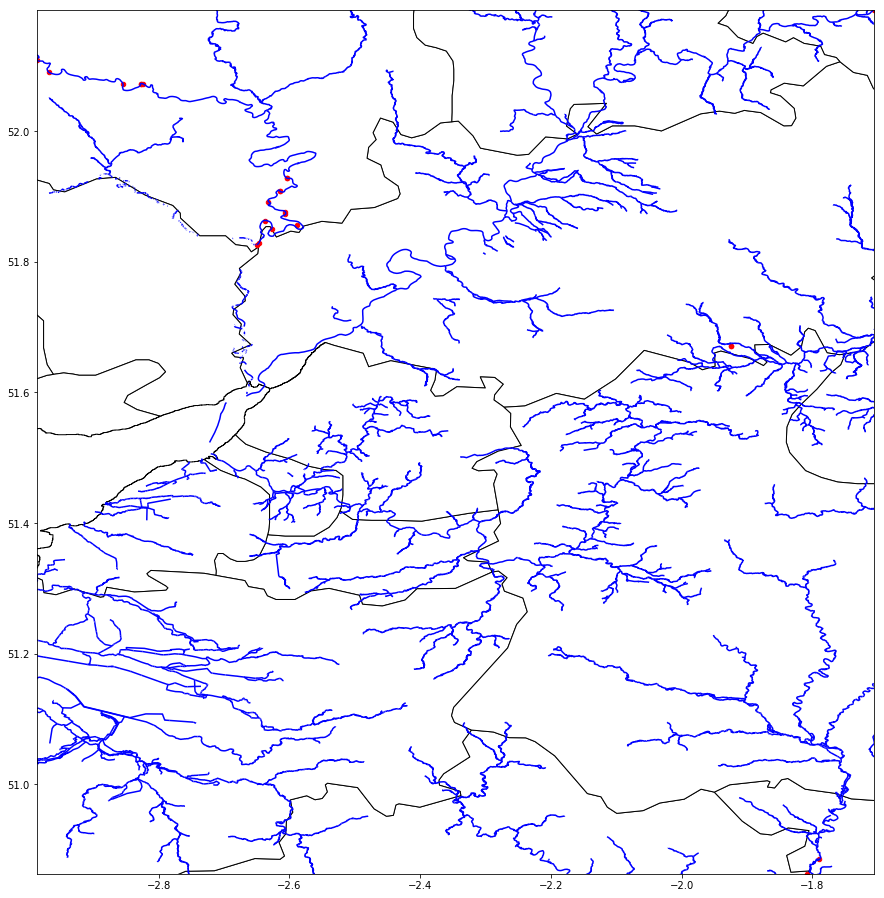

In [2]:
#load shapefile for UK
uk_mainmap=gpd.read_file('/home/sozbothorbos/fishscrape2/shapefiles/GBR_adm/GBR_adm2.shp')

#load UK waterways and rescale
en_waterways=gpd.read_file('/home/sozbothorbos/fishscrape2/shapefiles/main_rivers_en/data/Statutory_Main_River_Map.shp')
crs={'init':'epsg:4326'}
en_waterways = en_waterways.to_crs(crs=crs) 

#load the scraped point data
with open("test_logs.txt", "r") as file:
    data2 = eval(file.readline())
    

#create dataframe from found co-ords and convert to points
crs={'init':'epsg:4326'}
finds_df=pd.DataFrame(data2,columns = ['latitude' , 'longitude']) 
wronguns = finds_df[(finds_df['longitude'] > 0) | (finds_df['latitude'] > 58) | (finds_df['latitude'] < -50)  | (finds_df['longitude'] < -10)]
finds_df2=finds_df[~finds_df.isin(wronguns)]

geometry=[Point(xy) for xy in zip(finds_df2['longitude'],finds_df2['latitude'])]
geo_df=gpd.GeoDataFrame(finds_df,crs=crs,geometry=geometry)

#plot the data on map

%matplotlib inline
uk_ROI = uk_mainmap.query(" ['Wales', 'England'] in NAME_1 ")
fig,ax=plt.subplots(figsize=(15,25))
en_waterways.plot(ax = ax,color='blue')
uk_ROI.plot(ax = ax,color="white", edgecolor='black')
geo_df.plot( ax = ax, markersize=20, color='red', marker = 'o')

minx=finds_df2['longitude'].min()
maxx=finds_df2['longitude'].max()
miny=finds_df2['latitude'].min()
maxy=finds_df2['latitude'].max()
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)